<a href="https://colab.research.google.com/github/Shaon2221/Colab-Notebooks/blob/main/Merge_Family_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

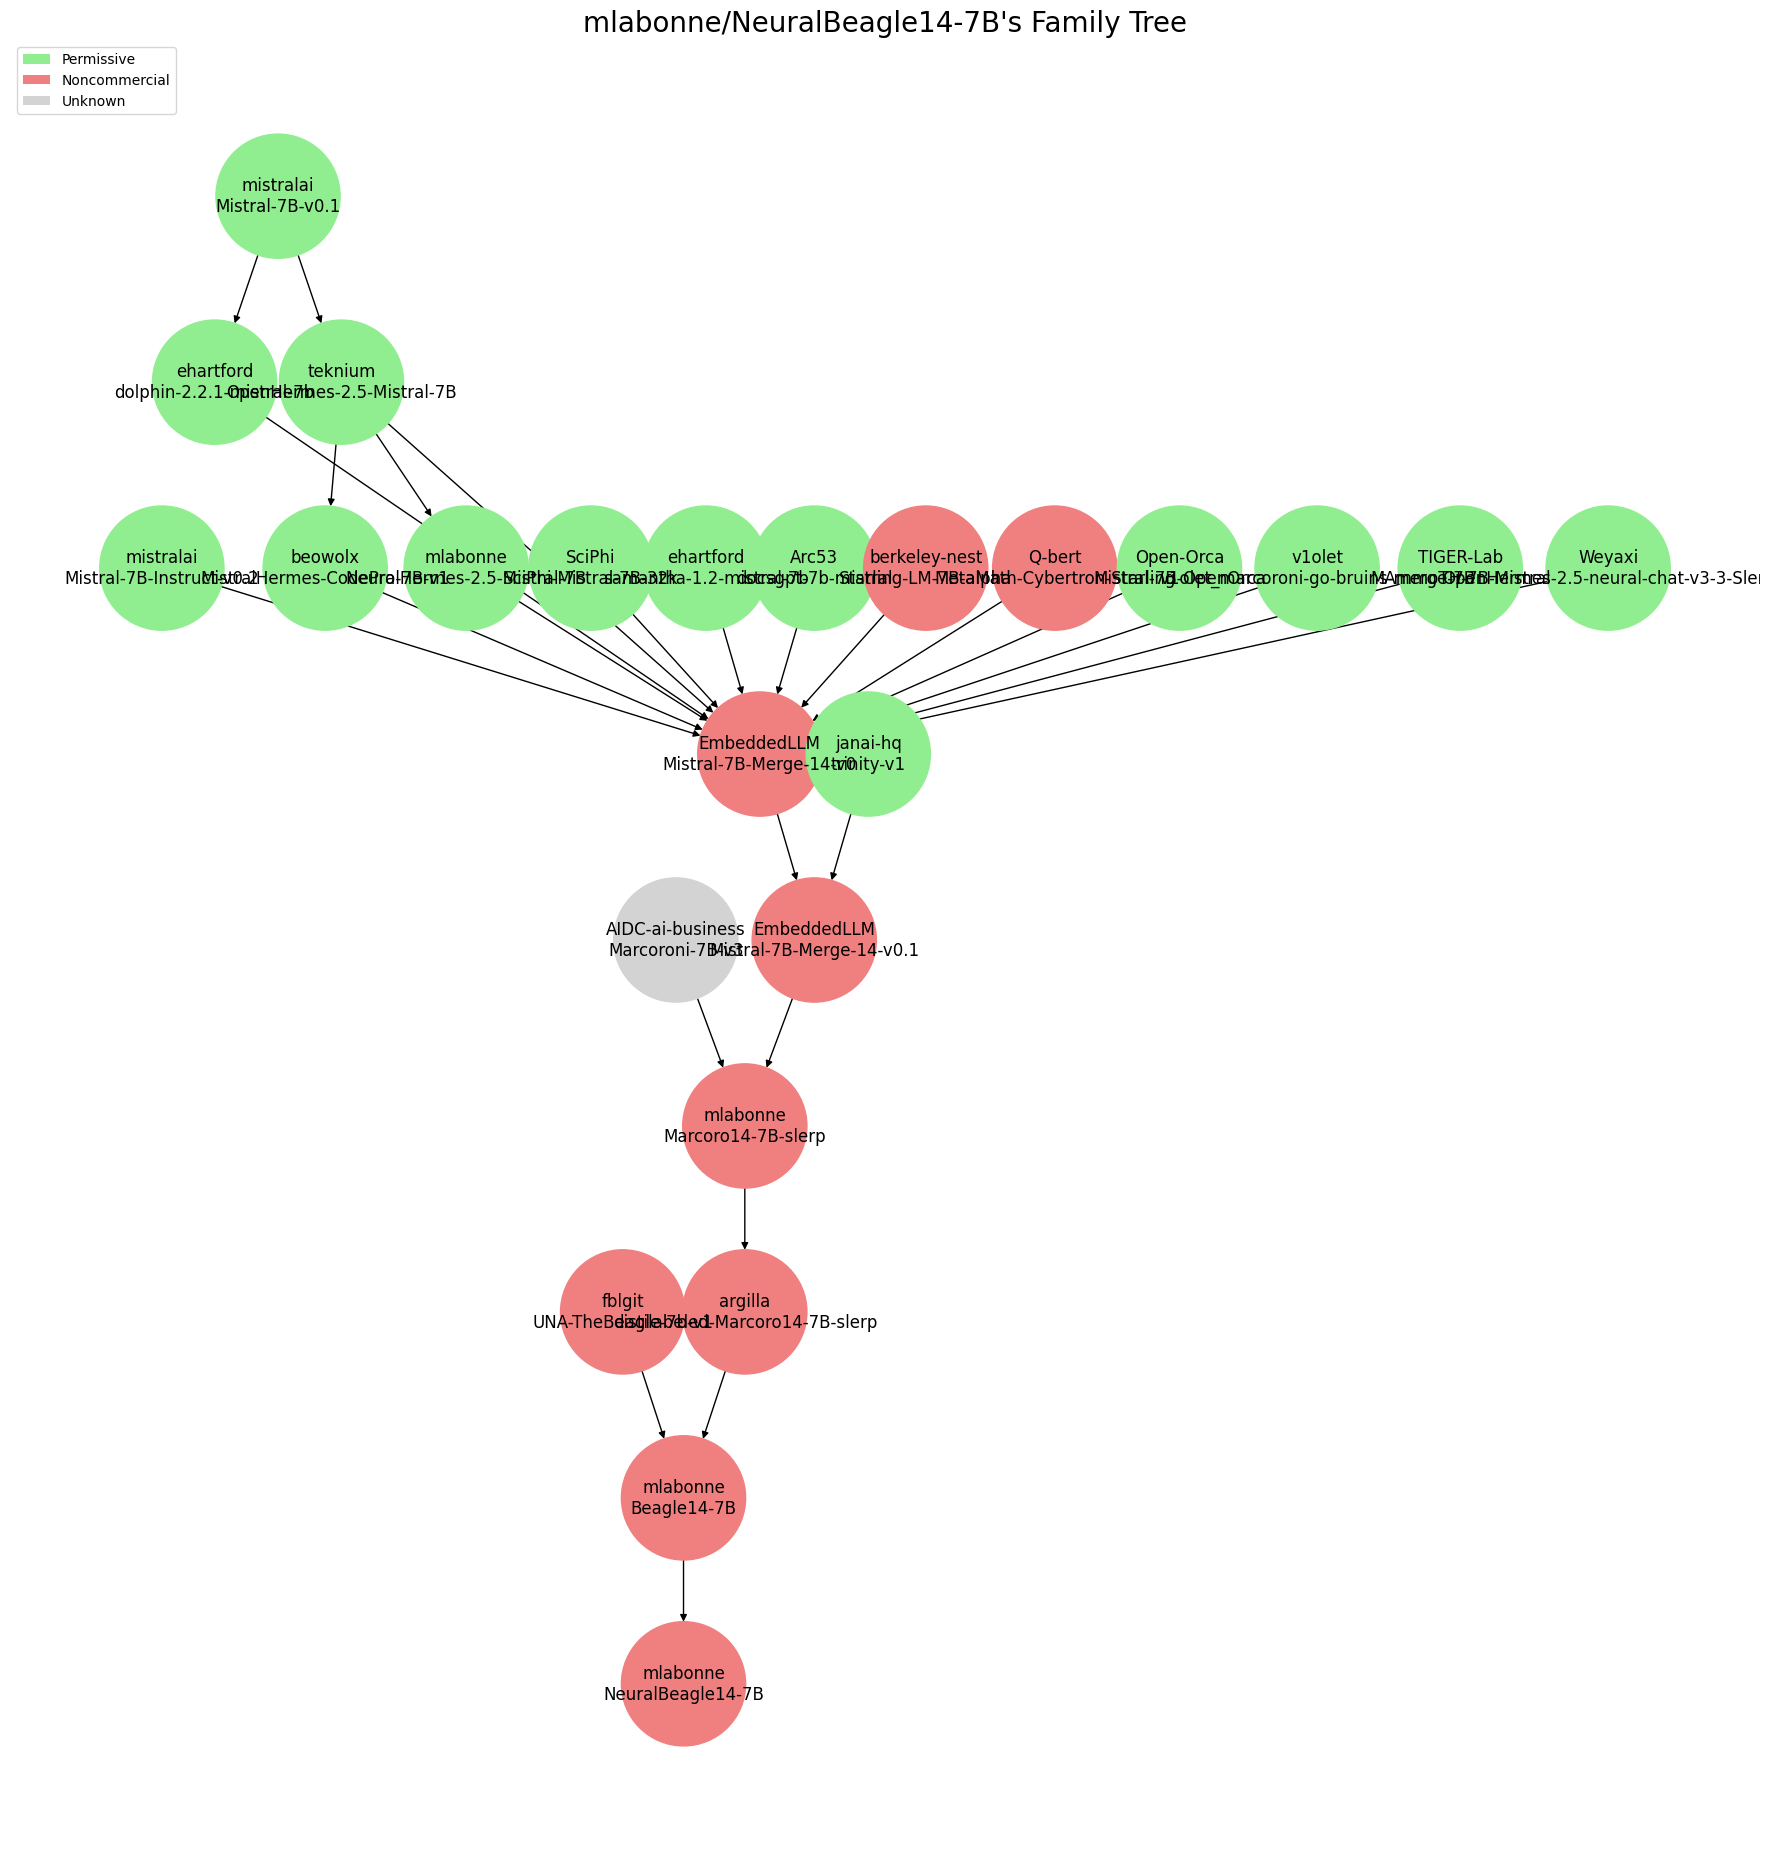

In [ ]:
# @title # 🌳 Model Family Tree
# @markdown Display the model family tree of a given [merge](https://huggingface.co/models?other=merge) based on metadata and yaml files.
!apt install -qq graphviz graphviz-dev
!pip install -qqq huggingface_hub pygraphviz --progress-bar off

from huggingface_hub import ModelCard, HfApi
import requests
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from collections import defaultdict
from networkx.drawing.nx_agraph import graphviz_layout
from IPython.display import clear_output

from bokeh.io import show, output_notebook
from bokeh.plotting import figure, from_networkx
from bokeh.models import ColumnDataSource, LabelSet, HoverTool
from bokeh.transform import linear_cmap
from networkx.drawing.layout import spring_layout

MODEL_ID = "mlabonne/NeuralBeagle14-7B" # @param {type:"string"}


def get_model_names_from_yaml(url):
    """Get a list of parent model names from the yaml file."""
    model_tags = []
    response = requests.get(url)
    if response.status_code == 200:
        model_tags.extend([item for item in response.content if '/' in str(item)])
    return model_tags


def get_license_color(model):
    """Get the color of the model based on its license."""
    try:
        card = ModelCard.load(model)
        license = card.data.to_dict()['license'].lower()
        # Define permissive licenses
        permissive_licenses = ['mit', 'bsd', 'apache-2.0', 'openrail']  # Add more as needed
        # Check license type
        if any(perm_license in license for perm_license in permissive_licenses):
            return 'lightgreen'  # Permissive licenses
        else:
            return 'lightcoral'  # Noncommercial or other licenses
    except Exception as e:
        print(f"Error retrieving license for {model}: {e}")
        return 'lightgray'


def get_model_names(model, genealogy, found_models=None):
    """Get a list of parent model names from the model id."""
    model_tags = []

    if found_models is None:
        found_models = []

    try:
        card = ModelCard.load(model)
        card_dict = card.data.to_dict()  # Convert the ModelCard object to a dictionary
        license = card_dict['license']

        # Check the base_model in metadata
        if 'base_model' in card_dict:
            model_tags = card_dict['base_model']

        # Check the tags in metadata
        if 'tags' in card_dict and not model_tags:
            tags = card_dict['tags']
            model_tags = [model_name for model_name in tags if '/' in model_name]

        # Check for merge.yml and mergekit_config.yml if no model_tags found in the tags
        if not model_tags:
            model_tags.extend(get_model_names_from_yaml(f"https://huggingface.co/{model}/blob/main/merge.yml"))
        if not model_tags:
            model_tags.extend(get_model_names_from_yaml(f"https://huggingface.co/{model}/blob/main/mergekit_config.yml"))

        # Convert to a list if tags is not None or empty, else set to an empty list
        if not isinstance(model_tags, list):
            model_tags = [model_tags] if model_tags else []

        # Add found model names to the list
        found_models.extend(model_tags)

        # Record the genealogy
        for model_tag in model_tags:
            genealogy[model_tag].append(model)

        # Recursively check for more models
        for model_tag in model_tags:
            get_model_names(model_tag, genealogy, found_models)

    except Exception as e:
        print(f"Could not find model names for {model}: {e}")

    return found_models


def find_root_nodes(G):
    """ Find all nodes in the graph with no predecessors """
    return [n for n, d in G.in_degree() if d == 0]


def max_width_of_tree(G):
    """ Calculate the maximum width of the tree """
    max_width = 0
    for root in find_root_nodes(G):
        width_at_depth = calculate_width_at_depth(G, root)
        local_max_width = max(width_at_depth.values())
        max_width = max(max_width, local_max_width)
    return max_width


def calculate_width_at_depth(G, root):
    """ Calculate width at each depth starting from a given root """
    depth_count = defaultdict(int)
    queue = [(root, 0)]
    while queue:
        node, depth = queue.pop(0)
        depth_count[depth] += 1
        for child in G.successors(node):
            queue.append((child, depth + 1))
    return depth_count


def create_family_tree(start_model):
    genealogy = defaultdict(list)
    get_model_names(start_model, genealogy)  # Assuming this populates the genealogy

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes and edges to the graph
    for parent, children in genealogy.items():
        for child in children:
            G.add_edge(parent, child)

    # Get max depth
    max_depth = nx.dag_longest_path_length(G) + 1

    # Get max width
    max_width = max_width_of_tree(G) + 1

    # Estimate plot size
    height = max(8, 2 * max_depth)
    width = max(8, 3.5 * max_width)

    # Set Graphviz layout attributes for a bottom-up tree
    plt.figure(figsize=(width, height))
    pos = graphviz_layout(G, prog="dot")

    # Determine node colors based on license
    node_colors = [get_license_color(node) for node in G.nodes()]
    clear_output()

    # Create a label mapping with line breaks
    labels = {node: node.replace("/", "\n") for node in G.nodes()}

    # Draw the graph
    nx.draw(G, pos, labels=labels, with_labels=True, node_color=node_colors, font_size=12, node_size=8_000, edge_color='black')

    # Create a legend for the colors
    legend_elements = [
        Patch(facecolor='lightgreen', label='Permissive'),
        Patch(facecolor='lightcoral', label='Noncommercial'),
        Patch(facecolor='lightgray', label='Unknown')
    ]
    plt.legend(handles=legend_elements, loc='upper left')

    plt.title(f"{start_model}'s Family Tree", fontsize=20)
    plt.show()

create_family_tree(MODEL_ID)